# Predict Student Performance from Game Play
### Goal: The objective of this competition is to use time series data generated by an online educational game to determine whether players will answer questions correctly.
-  There are three question checkpoints (level 4, level 12, and level 22), each with a number of questions.
- At each checkpoint, you will have access to all previous test data for that section.

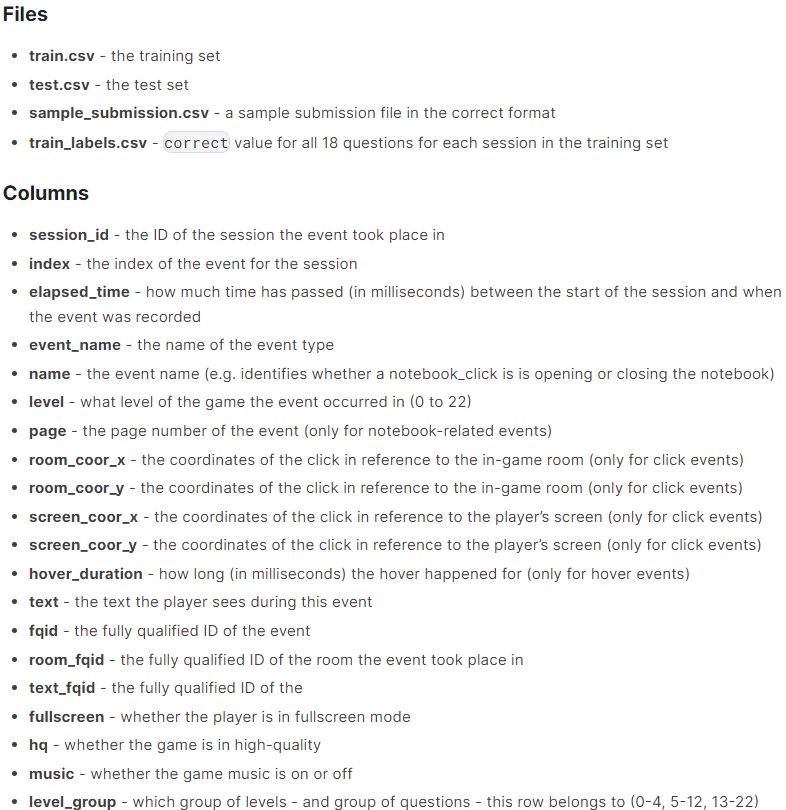 

# 0. Import Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import opendatasets as od
import os

In [2]:
os.listdir('data')

['jo_wilder',
 'sample_submission.csv',
 'test.csv',
 'train.csv',
 'train_labels.csv']

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train_labels = pd.read_csv('data/train_labels.csv')
submission = pd.read_csv('data/sample_submission.csv')

# 1. EDA

In [4]:
train

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13174206,22100221145014656,1600,5483231,navigate_click,undefined,22,NaN,343.887291,36.701026,483.0,273.0,NaN,NaN,NaN,tunic.capitol_2.hall,NaN,NaN,NaN,NaN,13-22
13174207,22100221145014656,1601,5485166,navigate_click,undefined,22,NaN,332.696070,141.493178,545.0,221.0,NaN,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,NaN,NaN,NaN,13-22
13174208,22100221145014656,1602,5485917,navigate_click,undefined,22,NaN,369.912859,140.569205,611.0,217.0,NaN,NaN,NaN,tunic.capitol_2.hall,NaN,NaN,NaN,NaN,13-22
13174209,22100221145014656,1603,5486753,navigate_click,undefined,22,NaN,252.299653,123.805889,526.0,232.0,NaN,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,NaN,NaN,NaN,13-22


## 20 Columns, 7 are string

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13174211 entries, 0 to 13174210
Data columns (total 20 columns):
 #   Column          Dtype  
---  ------          -----  
 0   session_id      int64  
 1   index           int64  
 2   elapsed_time    int64  
 3   event_name      object 
 4   name            object 
 5   level           int64  
 6   page            float64
 7   room_coor_x     float64
 8   room_coor_y     float64
 9   screen_coor_x   float64
 10  screen_coor_y   float64
 11  hover_duration  float64
 12  text            object 
 13  fqid            object 
 14  room_fqid       object 
 15  text_fqid       object 
 16  fullscreen      float64
 17  hq              float64
 18  music           float64
 19  level_group     object 
dtypes: float64(9), int64(4), object(7)
memory usage: 2.0+ GB


## Check Test Set

In [6]:
# Test set is tiny, 3k rows, and only 3 diffferent session ids
print(len(test))
print(test.session_id.value_counts())

3728
20090312143683264    1501
20090109393214576    1262
20090312331414616     965
Name: session_id, dtype: int64


## Check Train Label Set
- Each session will have 18 rows, representing 18 questions.

In [7]:
train_labels

,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090314121766812_q1,1
3,20090314363702160_q1,1
4,20090314441803444_q1,1
...,...,...
212017,22100215342220508_q18,1
212018,22100215460321130_q18,1
212019,22100217104993650_q18,1
212020,22100219442786200_q18,1


In [8]:
train_labels['session_id'][0]


'20090312431273200_q1'

In [9]:
train_labels[train_labels['session_id']=='20090312431273200_q1']

,session_id,correct
0,20090312431273200_q1,1


In [10]:
train_labels.session_id.value_counts()

20090312431273200_q1     1
20090314441803444_q13    1
22100215241104530_q12    1
22100215342220508_q12    1
22100215460321130_q12    1
                        ..
20090314121766812_q7     1
20090314363702160_q7     1
20090314441803444_q7     1
20090315081004164_q7     1
22100221145014656_q18    1
Name: session_id, Length: 212022, dtype: int64

In [11]:
train_labels_cp = train_labels.copy()
train_labels_cp['question'] = train_labels_cp['session_id'].str.split('_')
train_labels_cp


,session_id,correct,question
0,20090312431273200_q1,1,"[20090312431273200, q1]"
1,20090312433251036_q1,0,"[20090312433251036, q1]"
2,20090314121766812_q1,1,"[20090314121766812, q1]"
3,20090314363702160_q1,1,"[20090314363702160, q1]"
4,20090314441803444_q1,1,"[20090314441803444, q1]"
...,...,...,...
212017,22100215342220508_q18,1,"[22100215342220508, q18]"
212018,22100215460321130_q18,1,"[22100215460321130, q18]"
212019,22100217104993650_q18,1,"[22100217104993650, q18]"
212020,22100219442786200_q18,1,"[22100219442786200, q18]"


In [42]:
train.select_dtypes(object)

,event_name,name,text,fqid,room_fqid,text_fqid,level_group
0,cutscene_click,basic,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0-4
1,person_click,basic,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4
2,person_click,basic,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4
3,person_click,basic,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4
4,person_click,basic,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4
...,...,...,...,...,...,...,...
13174206,navigate_click,undefined,NaN,NaN,tunic.capitol_2.hall,NaN,13-22
13174207,navigate_click,undefined,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,13-22
13174208,navigate_click,undefined,NaN,NaN,tunic.capitol_2.hall,NaN,13-22
13174209,navigate_click,undefined,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,13-22


In [14]:
train[train['session_id']==20090312431273200]

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,20090312431273200,927,1267357,navigate_click,undefined,22,NaN,927.307255,-10.355929,838.0,335.0,NaN,NaN,tomap,tunic.historicalsociety.entry,NaN,NaN,NaN,NaN,13-22
877,20090312431273200,928,1268292,map_hover,basic,22,NaN,NaN,NaN,NaN,NaN,366.0,NaN,tomap,tunic.historicalsociety.entry,NaN,NaN,NaN,NaN,13-22
878,20090312431273200,929,1269474,map_click,undefined,22,NaN,457.523005,22.141338,443.0,316.0,NaN,NaN,tunic.capitol_2,tunic.historicalsociety.entry,NaN,NaN,NaN,NaN,13-22
879,20090312431273200,930,1270708,navigate_click,undefined,22,NaN,224.190321,-60.268671,404.0,337.0,NaN,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,NaN,NaN,NaN,13-22


## fullscreen, hq, music, is all null

In [15]:
train.page.value_counts()

5.0    51154
1.0    50714
6.0    45417
4.0    44207
0.0    37232
3.0    31350
2.0    24672
Name: page, dtype: int64

## Only 11k different session ids, out of 13million rows in data

In [16]:
train.session_id.value_counts()

20110310463989760    19032
20110515090304556     6000
21110313432157404     5435
21040313423932212     4248
20110219261342890     4215
                     ...  
21100511290882536      645
21010304415056110      644
21090109332150240      639
21030218335394260      639
20110112402567744      634
Name: session_id, Length: 11779, dtype: int64

In [17]:
train.session_id.value_counts()

20110310463989760    19032
20110515090304556     6000
21110313432157404     5435
21040313423932212     4248
20110219261342890     4215
                     ...  
21100511290882536      645
21010304415056110      644
21090109332150240      639
21030218335394260      639
20110112402567744      634
Name: session_id, Length: 11779, dtype: int64

## Initiala EDA Thoughts
- data is 20col, 7 string
- test set is tiny with only 3 different sessions
- train labels have no reoccuring session id, question pairs
- fullscreen, hq, music column is all null - so can remove
- each session id has many rows
- Only 11k different session ids, out of 13million rows in data

In [18]:
train

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13174206,22100221145014656,1600,5483231,navigate_click,undefined,22,NaN,343.887291,36.701026,483.0,273.0,NaN,NaN,NaN,tunic.capitol_2.hall,NaN,NaN,NaN,NaN,13-22
13174207,22100221145014656,1601,5485166,navigate_click,undefined,22,NaN,332.696070,141.493178,545.0,221.0,NaN,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,NaN,NaN,NaN,13-22
13174208,22100221145014656,1602,5485917,navigate_click,undefined,22,NaN,369.912859,140.569205,611.0,217.0,NaN,NaN,NaN,tunic.capitol_2.hall,NaN,NaN,NaN,NaN,13-22
13174209,22100221145014656,1603,5486753,navigate_click,undefined,22,NaN,252.299653,123.805889,526.0,232.0,NaN,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,NaN,NaN,NaN,13-22


13 million rows, room coor and screen coor have 7% nulls
- parts of the games without mouse movement?

In [19]:
train.isnull().sum()

session_id               0
index                    0
elapsed_time             0
event_name               0
name                     0
level                    0
page              12889465
room_coor_x        1036240
room_coor_y        1036240
screen_coor_x      1036240
screen_coor_y      1036240
hover_duration    12173474
text               8367320
fqid               4159648
room_fqid                0
text_fqid          8367266
fullscreen        13174211
hq                13174211
music             13174211
level_group              0
dtype: int64

# Column Null Percentage

In [20]:
train.isnull().sum()/len(train)*100

session_id          0.000000
index               0.000000
elapsed_time        0.000000
event_name          0.000000
name                0.000000
level               0.000000
page               97.838611
room_coor_x         7.865670
room_coor_y         7.865670
screen_coor_x       7.865670
screen_coor_y       7.865670
hover_duration     92.403818
text               63.512874
fqid               31.574172
room_fqid           0.000000
text_fqid          63.512464
fullscreen        100.000000
hq                100.000000
music             100.000000
level_group         0.000000
dtype: float64

In [21]:
train.page.value_counts()

5.0    51154
1.0    50714
6.0    45417
4.0    44207
0.0    37232
3.0    31350
2.0    24672
Name: page, dtype: int64

In [22]:
train.hover_duration.value_counts()

17.0       31285
50.0       24917
33.0       18857
16.0       18662
67.0       13077
           ...  
14913.0        1
29081.0        1
17487.0        1
17754.0        1
11060.0        1
Name: hover_duration, Length: 19474, dtype: int64

In [23]:
train.hover_duration.isna().value_counts()

True     12173474
False     1000737
Name: hover_duration, dtype: int64

In [24]:
print(train.fullscreen.isna().value_counts())


True    13174211
Name: fullscreen, dtype: int64


In [25]:
train.fullscreen

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
            ..
13174206   NaN
13174207   NaN
13174208   NaN
13174209   NaN
13174210   NaN
Name: fullscreen, Length: 13174211, dtype: float64

# Drop 100% null columns

In [26]:
train.drop(columns=['fullscreen', 'hq', 'music'], inplace=True)
train

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13174206,22100221145014656,1600,5483231,navigate_click,undefined,22,NaN,343.887291,36.701026,483.0,273.0,NaN,NaN,NaN,tunic.capitol_2.hall,NaN,13-22
13174207,22100221145014656,1601,5485166,navigate_click,undefined,22,NaN,332.696070,141.493178,545.0,221.0,NaN,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,13-22
13174208,22100221145014656,1602,5485917,navigate_click,undefined,22,NaN,369.912859,140.569205,611.0,217.0,NaN,NaN,NaN,tunic.capitol_2.hall,NaN,13-22
13174209,22100221145014656,1603,5486753,navigate_click,undefined,22,NaN,252.299653,123.805889,526.0,232.0,NaN,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,13-22


In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13174211 entries, 0 to 13174210
Data columns (total 17 columns):
 #   Column          Dtype  
---  ------          -----  
 0   session_id      int64  
 1   index           int64  
 2   elapsed_time    int64  
 3   event_name      object 
 4   name            object 
 5   level           int64  
 6   page            float64
 7   room_coor_x     float64
 8   room_coor_y     float64
 9   screen_coor_x   float64
 10  screen_coor_y   float64
 11  hover_duration  float64
 12  text            object 
 13  fqid            object 
 14  room_fqid       object 
 15  text_fqid       object 
 16  level_group     object 
dtypes: float64(6), int64(4), object(7)
memory usage: 1.7+ GB


In [28]:
train_labels

,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090314121766812_q1,1
3,20090314363702160_q1,1
4,20090314441803444_q1,1
...,...,...
212017,22100215342220508_q18,1
212018,22100215460321130_q18,1
212019,22100217104993650_q18,1
212020,22100219442786200_q18,1


In [29]:
sess1_list = []
for i in range (1, 18):
    print(train_labels[train_labels['session_id']=='20090312431273200_q{}'.format(i)])
    sess1_list.append(train_labels[train_labels['session_id'] == '20090312431273200_q{}'.format(i)])
#print(train_labels[train_labels['session_id']=='20090312431273200_q1'])

             session_id  correct
0  20090312431273200_q1        1
                 session_id  correct
11779  20090312431273200_q2        1
                 session_id  correct
23558  20090312431273200_q3        1
                 session_id  correct
35337  20090312431273200_q4        1
                 session_id  correct
47116  20090312431273200_q5        1
                 session_id  correct
58895  20090312431273200_q6        1
                 session_id  correct
70674  20090312431273200_q7        1
                 session_id  correct
82453  20090312431273200_q8        1
                 session_id  correct
94232  20090312431273200_q9        1
                   session_id  correct
106011  20090312431273200_q10        1
                   session_id  correct
117790  20090312431273200_q11        1
                   session_id  correct
129569  20090312431273200_q12        1
                   session_id  correct
141348  20090312431273200_q13        0
                   session_id 

In [30]:
len(sess1_list)

17

# Get first session

In [31]:
sess1 = train[train['session_id']==20090312431273200]
sess1

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,20090312431273200,927,1267357,navigate_click,undefined,22,NaN,927.307255,-10.355929,838.0,335.0,NaN,NaN,tomap,tunic.historicalsociety.entry,NaN,13-22
877,20090312431273200,928,1268292,map_hover,basic,22,NaN,NaN,NaN,NaN,NaN,366.0,NaN,tomap,tunic.historicalsociety.entry,NaN,13-22
878,20090312431273200,929,1269474,map_click,undefined,22,NaN,457.523005,22.141338,443.0,316.0,NaN,NaN,tunic.capitol_2,tunic.historicalsociety.entry,NaN,13-22
879,20090312431273200,930,1270708,navigate_click,undefined,22,NaN,224.190321,-60.268671,404.0,337.0,NaN,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,13-22


# Check values of categorical columns

In [32]:
sess1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 881 entries, 0 to 880
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   session_id      881 non-null    int64  
 1   index           881 non-null    int64  
 2   elapsed_time    881 non-null    int64  
 3   event_name      881 non-null    object 
 4   name            881 non-null    object 
 5   level           881 non-null    int64  
 6   page            0 non-null      float64
 7   room_coor_x     813 non-null    float64
 8   room_coor_y     813 non-null    float64
 9   screen_coor_x   813 non-null    float64
 10  screen_coor_y   813 non-null    float64
 11  hover_duration  65 non-null     float64
 12  text            384 non-null    object 
 13  fqid            652 non-null    object 
 14  room_fqid       881 non-null    object 
 15  text_fqid       384 non-null    object 
 16  level_group     881 non-null    object 
dtypes: float64(6), int64(4), object(7)


In [33]:
# name of event type
sess1.event_name.value_counts()

navigate_click        354
person_click          249
cutscene_click        100
object_click           59
object_hover           38
notification_click     27
map_hover              27
map_click              16
observation_click       8
checkpoint              3
Name: event_name, dtype: int64

In [34]:
# the event name
sess1.name.value_counts()

basic        463
undefined    401
close         17
Name: name, dtype: int64

In [35]:
train.name.value_counts()

undefined    6377305
basic        6324016
close         339093
open          118125
prev            9834
next            5838
Name: name, dtype: int64

In [36]:
# text player sees during event
sess1.text.value_counts()

undefined                                                          13
\u00f0\u0178\u02dc\u00b4                                            3
I need to get her free. She won't hold still!                       2
Maybe she'll let me take off the cup!                               2
Got one!                                                            2
                                                                   ..
Maybe I can help!                                                   1
Now I Just need to find all the cleaners from way back in 1916.     1
Thanks.                                                             1
Looks like a dry cleaning receipt.                                  1
I should go to the Capitol and tell Mrs. M!                         1
Name: text, Length: 344, dtype: int64

In [37]:
# fqid - the fully qualified ID of the event
sess1.fqid.value_counts()

worker                64
archivist             46
gramps                44
crane_ranger          32
wells                 32
                      ..
tunic.humanecology     1
tunic.wildlife         1
tocollectionflag       1
reader.paper1.next     1
intro                  1
Name: fqid, Length: 95, dtype: int64

In [38]:
# room_fqid - the fully qualified ID of the room the event took place in
sess1.room_fqid.value_counts()


tunic.historicalsociety.entry              123
tunic.wildlife.center                      104
tunic.historicalsociety.cage                83
tunic.historicalsociety.frontdesk           73
tunic.library.frontdesk                     58
tunic.historicalsociety.basement            53
tunic.historicalsociety.closet_dirty        50
tunic.historicalsociety.closet              47
tunic.humanecology.frontdesk                44
tunic.historicalsociety.stacks              42
tunic.drycleaner.frontdesk                  33
tunic.kohlcenter.halloffame                 33
tunic.flaghouse.entry                       32
tunic.historicalsociety.collection          30
tunic.library.microfiche                    28
tunic.capitol_1.hall                        23
tunic.historicalsociety.collection_flag     12
tunic.capitol_0.hall                        11
tunic.capitol_2.hall                         2
Name: room_fqid, dtype: int64

In [39]:
#text_fqid - the fully qualified ID of the 
print(sess1.text_fqid.value_counts())
print(len(sess1.text_fqid.value_counts()))


tunic.wildlife.center.crane_ranger.crane                       30
tunic.historicalsociety.cage.confrontation                     21
tunic.historicalsociety.frontdesk.archivist.newspaper          18
tunic.historicalsociety.entry.groupconvo                       16
tunic.wildlife.center.wells.nodeer                             16
                                                               ..
tunic.historicalsociety.frontdesk.key                           1
tunic.historicalsociety.frontdesk.magnify                       1
tunic.humanecology.frontdesk.businesscards.card_bingo.bingo     1
tunic.historicalsociety.cage.glasses.beforeteddy                1
tunic.historicalsociety.closet.intro                            1
Name: text_fqid, Length: 76, dtype: int64
76


In [40]:
sess1[sess1.text_fqid.isna()]


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,level_group
10,20090312431273200,10,9133,navigate_click,undefined,0,NaN,501.110035,-160.748164,605.0,445.0,NaN,NaN,teddy,tunic.historicalsociety.closet,NaN,0-4
12,20090312431273200,12,12030,navigate_click,undefined,0,NaN,510.081490,-106.352093,614.0,386.0,NaN,NaN,photo,tunic.historicalsociety.closet,NaN,0-4
14,20090312431273200,14,14814,navigate_click,undefined,0,NaN,273.991410,-196.802371,406.0,486.0,NaN,NaN,NaN,tunic.historicalsociety.closet,NaN,0-4
15,20090312431273200,15,15498,navigate_click,undefined,0,NaN,185.708460,-205.806533,363.0,492.0,NaN,NaN,NaN,tunic.historicalsociety.closet,NaN,0-4
16,20090312431273200,16,16046,navigate_click,undefined,0,NaN,0.583565,-225.691296,234.0,510.0,NaN,NaN,NaN,tunic.historicalsociety.closet,NaN,0-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,20090312431273200,927,1267357,navigate_click,undefined,22,NaN,927.307255,-10.355929,838.0,335.0,NaN,NaN,tomap,tunic.historicalsociety.entry,NaN,13-22
877,20090312431273200,928,1268292,map_hover,basic,22,NaN,NaN,NaN,NaN,NaN,366.0,NaN,tomap,tunic.historicalsociety.entry,NaN,13-22
878,20090312431273200,929,1269474,map_click,undefined,22,NaN,457.523005,22.141338,443.0,316.0,NaN,NaN,tunic.capitol_2,tunic.historicalsociety.entry,NaN,13-22
879,20090312431273200,930,1270708,navigate_click,undefined,22,NaN,224.190321,-60.268671,404.0,337.0,NaN,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,13-22


In [41]:
# level_group - which group of levels - and group of questions - this row belongs to (0-4, 5-12, 13-22)
sess1.level_group.value_counts()

13-22    420
5-12     296
0-4      165
Name: level_group, dtype: int64

# Conclusion
1. Get rid of columns with high # of null values
2. One hot encode string columns
3. Aggregate train rows to match # of questions rows in train_lables